# Projekat 1 - Nadgledano učenje

***Nastasija Stanković 1622   
Katarina Stanojković 1773***

## Podaci o datasetu

Dataset: https://archive.ics.uci.edu/dataset/864/room+occupancy+estimation   

Dataset je prikupljen u eksperimentalnom okruženju gde je praćena estimacija zauzetosti prostorije dimenzija 6m x 4.6m. Postavka se sastojala od 7 senzorskih čvorova i jednog čvora na ivici mreže (edge node) u konfiguraciji zvezde, gde su senzorski čvorovi svakih 30 sekundi slali podatke ka čvoru na ivici pomoću bežičnih transivera.    

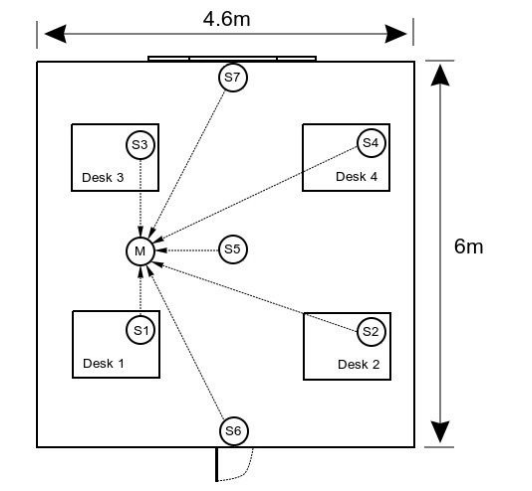   

Na osnovu parametra potrebno je odrediti koliko osoba se nalazi u prostoriji 0,1,2 ili 3 (višeklasna klasifikacija)


## Priprema podataka

### Importovanje biblioteka

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split,cross_validate, KFold,cross_val_score,cross_val_predict,RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier,StackingClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif,VarianceThreshold,SelectKBest,SelectPercentile,SelectFromModel
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix, log_loss,make_scorer,precision_recall_curve,average_precision_score
import warnings

In [2]:
warnings.filterwarnings('ignore')

### Učitavanje podataka

In [20]:
data = pd.read_csv("Occupancy_Estimation.csv")

### Prikaz podataka

In [21]:
data.head(10)

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
5,2017/12/22,10:52:14,25.00,24.81,24.56,25.44,121,34,54,40,0.13,0.06,0.06,0.07,390,0.165385,0,0,1
6,2017/12/22,10:52:45,25.00,24.75,24.56,25.44,120,34,54,40,1.39,0.32,0.43,0.06,390,0.076923,1,0,1
7,2017/12/22,10:53:15,25.00,24.81,24.56,25.44,121,34,54,41,0.09,0.06,0.09,0.05,390,-0.011538,0,0,1
8,2017/12/22,10:53:46,25.00,24.81,24.56,25.50,122,35,56,43,0.09,0.05,0.06,0.13,390,-0.100000,0,0,1
9,2017/12/22,10:54:17,25.00,24.81,24.56,25.50,101,34,57,43,3.84,0.64,0.48,0.39,390,-0.188462,1,1,1


**Date**: YYYY/MM/DD     
**Time**: HH:MM:SS     
**Temperature**: U stepenima Celzijusa (S1_Temp - S4_Temp). _Kontinualne numeričke vrednosti_      
**Light**: U luksima (S1_Light - S4_Light). _Numeričke vrednosti_     
**Sound**: U voltima (S1_Sound - S4_Sound). _Kontinualne numeričke vrednosti_     
**S5_CO2**: U PPM (delova CO2 po milionu delova vazduha). _Numeričke vrednosti_        
**CO2 Nagib (CO2 Slope)**: Nagib vrednosti CO2. _Kontinualne numeričke vrednosti_  
**PIR**: Binarna vrednost koja prenosi detekciju pokreta (S6_Pir i S7_Pir).       
**Room_Occupancy_Count**: Broj osoba u prostoriji. _Numeričke vrednosti_    

### Tipovi podataka

In [41]:
data.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

Svi atributi osim Date i Time atributa su numerički. Kako bi se podaci pripremili za primenu algoritma mašinskog učenja potrebno je da i njih pretvorimo u numeričke.    
Na početku ćemo da ih spojimo u jedan atribut DateTime a nakon toga i u timestamp.

In [22]:
#Spajanje Date i Time u jedan atribut
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.drop(['Date', 'Time'], axis=1, inplace=True)

#Pretvaranje DateTime u timestamp
data['Timestamp'] = data['DateTime'].astype('int64') // 10**9
data = data.drop(["DateTime"], axis=1)

data.dtypes

S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
Timestamp                 int64
dtype: object

### Provera nedostajućih vrednosti

In [43]:
data.isna().sum()

S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
Timestamp               0
dtype: int64

### Broj instanci u dataset-u

In [44]:
len(data)

10129

### Brisanje duplikata

In [45]:
dups = data.duplicated()
print("Broj duplikata pre brisanja:", dups.sum())
data.drop_duplicates(inplace=True)
print("Broj duplikata posle brisanja:", data.duplicated().sum())

Broj duplikata pre brisanja: 0
Broj duplikata posle brisanja: 0


### Deskriptivna statistika

In [46]:
data.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Timestamp
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,1.012900e+04
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559,1.514406e+09
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633,6.229260e+05
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000,1.513940e+09
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000,1.514020e+09
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000,1.514099e+09
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000,1.514264e+09
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000,1.515661e+09


Vrednosti za S3_Light i S5_CO2 imaju najveci opseg, pa je korisno ispitati njihovu distribuciju.

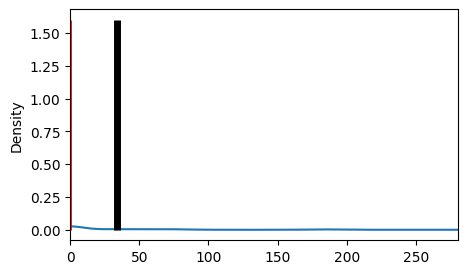

In [174]:
skewplot = data.S3_Light.plot(kind="density",
              figsize=(5,3),
              xlim=(data.S3_Light.min(),data.S3_Light.max()));
plt.vlines(data.S3_Light.mean(),
           ymin=0,
           ymax=1.6,
           linewidth=5.0,
           color="black");
plt.vlines(data.S3_Light.median(),
           ymin=0,
           ymax=1.6,
           linewidth=2.0,
           color="red");
plt.show()

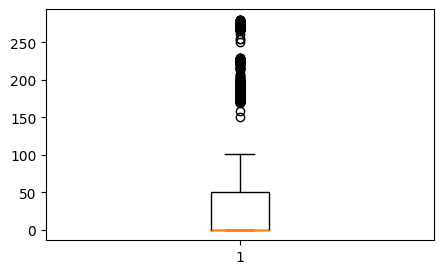

In [14]:
plt.figure(figsize=(5, 3))
boxplot = plt.boxplot(data.S3_Light)
plt.show()

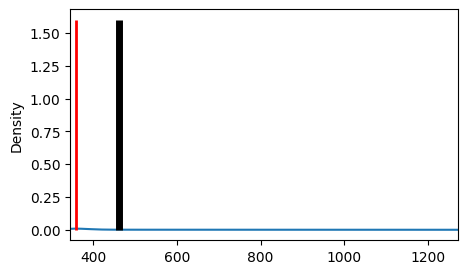

In [15]:
skewplot = data.S5_CO2.plot(kind="density",
              figsize=(5,3),
              xlim=(data.S5_CO2.min(),data.S5_CO2.max()));
plt.vlines(data.S5_CO2.mean(),
           ymin=0,
           ymax=1.6,
           linewidth=5.0,
           color="black");
plt.vlines(data.S5_CO2.median(),
           ymin=0,
           ymax=1.6,
           linewidth=2.0,
           color="red");
plt.show()

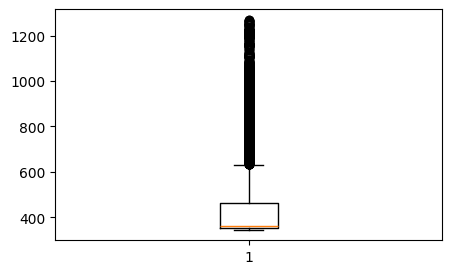

In [16]:
plt.figure(figsize=(5, 3))
boxplot = plt.boxplot(data.S5_CO2)
plt.show()

Na osnovu ovih grafika može se primetiti da ovi atributi imaju značajan broj outlier-a.Ali ih nećemo otklanjati zbog specifičnosti problema,podaci su osetljivi (sa senzora),i znajući da je dataset nebalansiran,većina je 0,ove vrednosti verovatno ne predstavljaju outlier-e već vrednosti za ostale klase (1,2,3).

### Raspodela podataka

array([[<Axes: title={'center': 'S1_Temp'}>,
        <Axes: title={'center': 'S2_Temp'}>,
        <Axes: title={'center': 'S3_Temp'}>,
        <Axes: title={'center': 'S4_Temp'}>],
       [<Axes: title={'center': 'S1_Light'}>,
        <Axes: title={'center': 'S2_Light'}>,
        <Axes: title={'center': 'S3_Light'}>,
        <Axes: title={'center': 'S4_Light'}>],
       [<Axes: title={'center': 'S1_Sound'}>,
        <Axes: title={'center': 'S2_Sound'}>,
        <Axes: title={'center': 'S3_Sound'}>,
        <Axes: title={'center': 'S4_Sound'}>],
       [<Axes: title={'center': 'S5_CO2'}>,
        <Axes: title={'center': 'S5_CO2_Slope'}>,
        <Axes: title={'center': 'S6_PIR'}>,
        <Axes: title={'center': 'S7_PIR'}>],
       [<Axes: title={'center': 'Room_Occupancy_Count'}>,
        <Axes: title={'center': 'Timestamp'}>, <Axes: >, <Axes: >]],
      dtype=object)

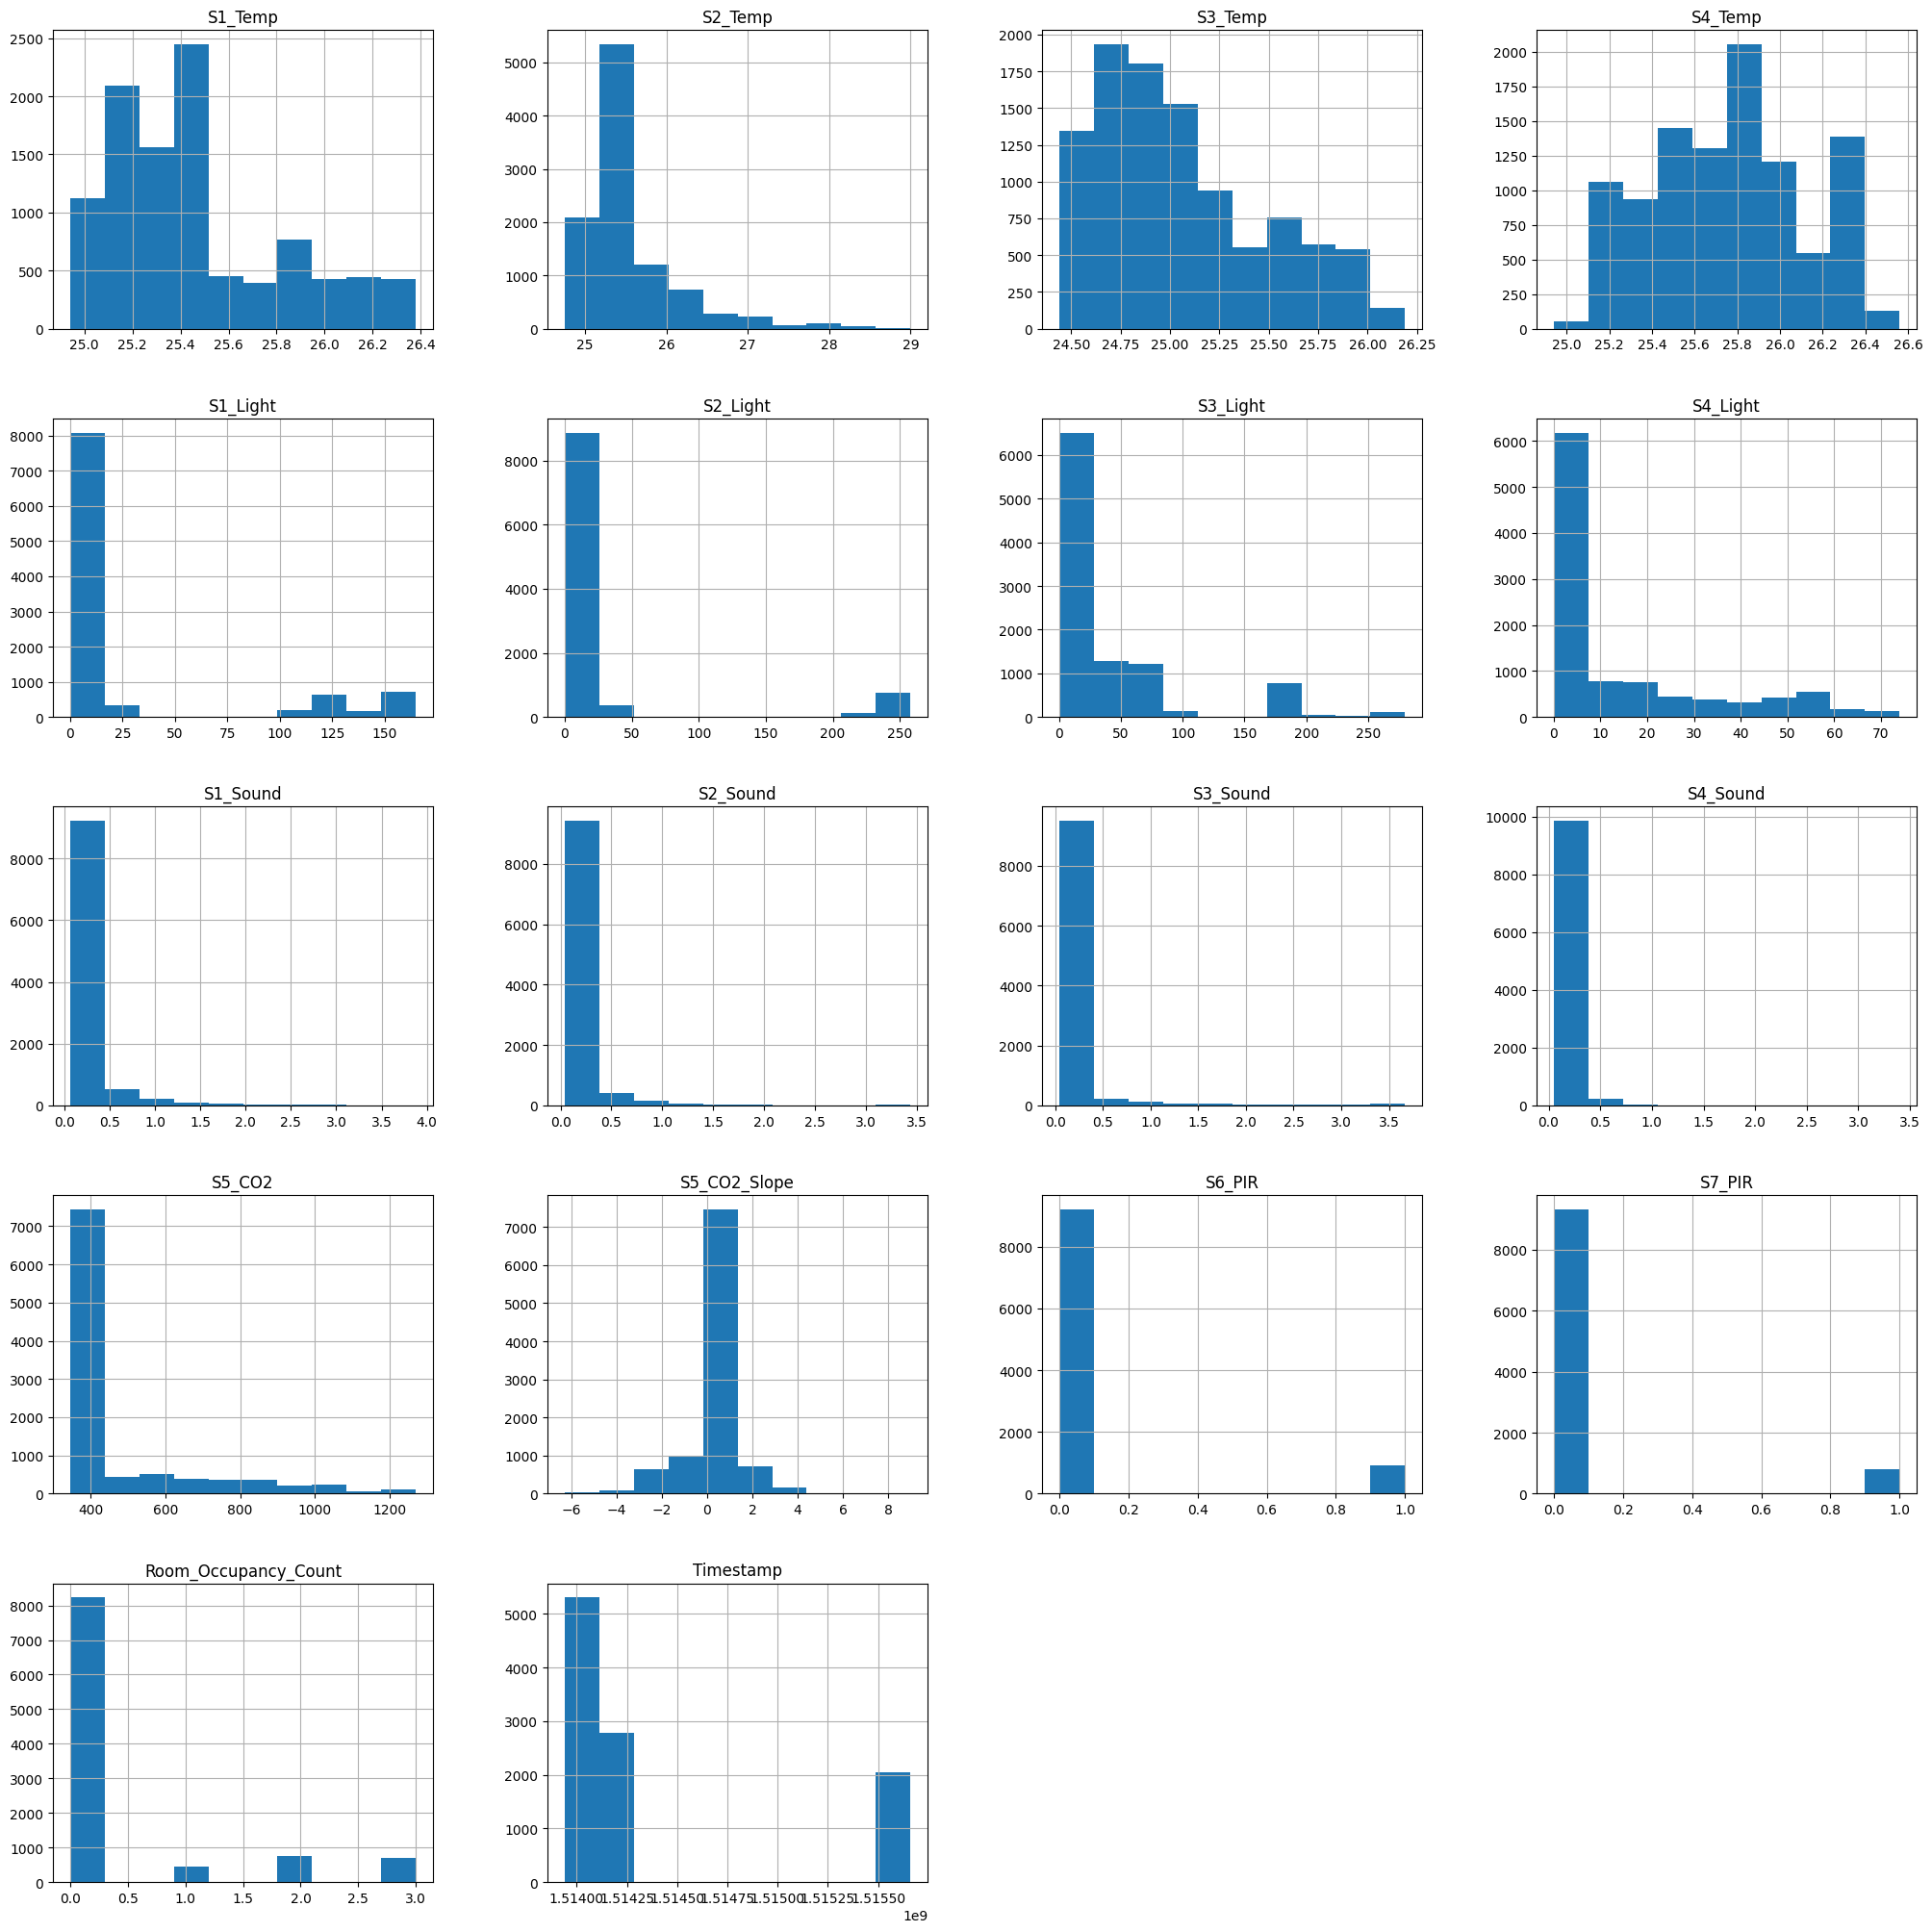

In [175]:
data.hist(figsize = (25,25))

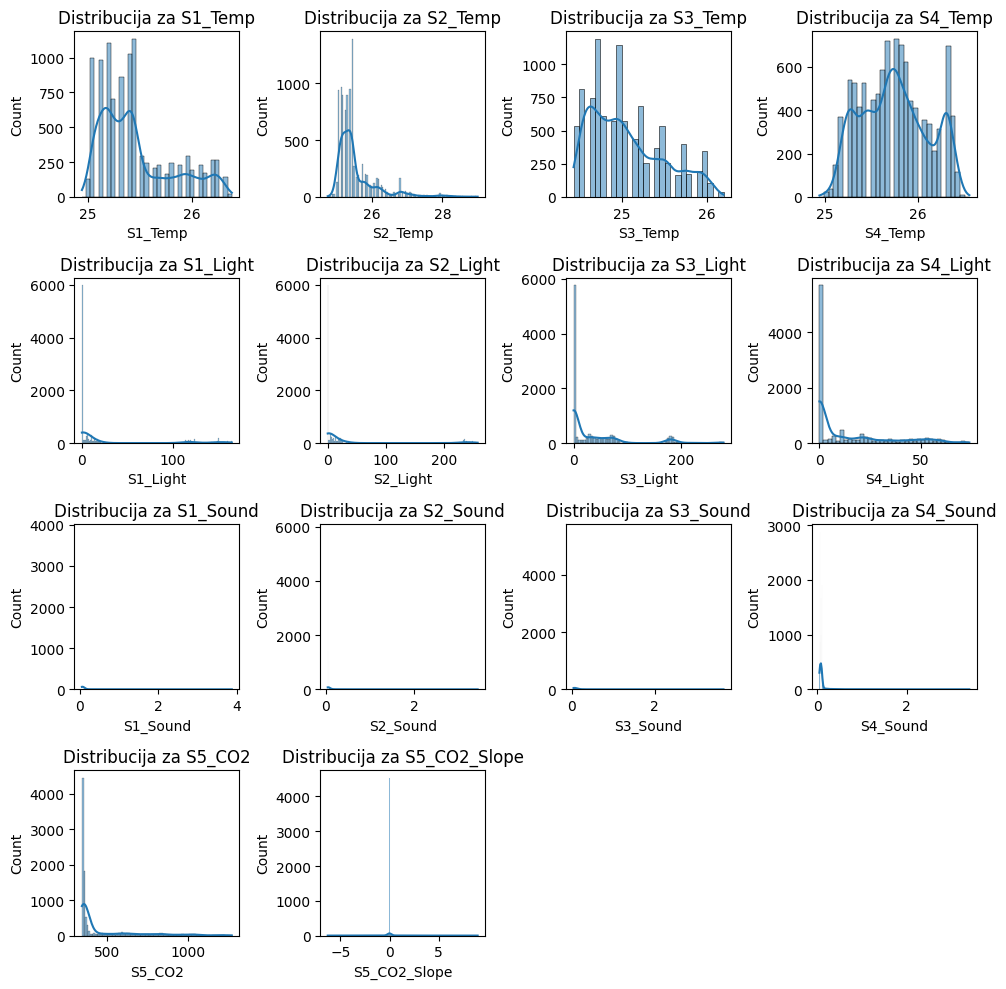

In [13]:
plt.figure(figsize=(10, 10))
columns_to_plot = data.columns[:-4]  

for i, column in enumerate(columns_to_plot):
    plt.subplot(4, 4, i + 1)
    sns.histplot(x=column, data=data, kde=True)
    plt.title(f'Distribucija za {column}')

plt.tight_layout()
plt.show()


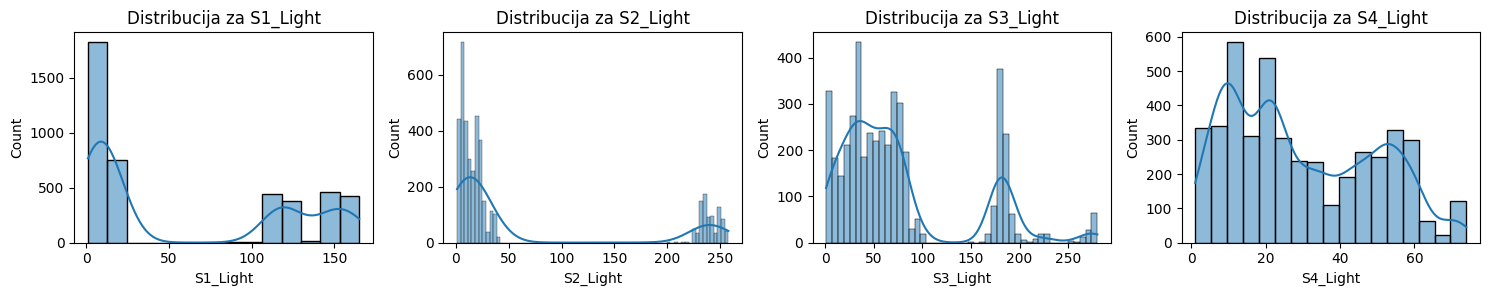

In [15]:
selected_columns = data.columns[4:8]

plt.figure(figsize=(15, 8))

for i, column in enumerate(selected_columns, 1):
    plt.subplot(3, 4, i)
    filtered_data = data.loc[data[column] > 0][column]
    sns.histplot(filtered_data, kde=True)
    plt.title(f'Distribucija za {column}')

plt.tight_layout()
plt.show()

In [102]:
len(filtered_data)

4530

### Korelacija izmedju varijabli

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 [Text(0.5, 0, 'S1_Temp'),
  Text(1.5, 0, 'S2_Temp'),
  Text(2.5, 0, 'S3_Temp'),
  Text(3.5, 0, 'S4_Temp'),
  Text(4.5, 0, 'S1_Light'),
  Text(5.5, 0, 'S2_Light'),
  Text(6.5, 0, 'S3_Light'),
  Text(7.5, 0, 'S4_Light'),
  Text(8.5, 0, 'S1_Sound'),
  Text(9.5, 0, 'S2_Sound'),
  Text(10.5, 0, 'S3_Sound'),
  Text(11.5, 0, 'S4_Sound'),
  Text(12.5, 0, 'S5_CO2'),
  Text(13.5, 0, 'S5_CO2_Slope'),
  Text(14.5, 0, 'S6_PIR'),
  Text(15.5, 0, 'S7_PIR'),
  Text(16.5, 0, 'Room_Occupancy_Count'),
  Text(17.5, 0, 'Timestamp')])

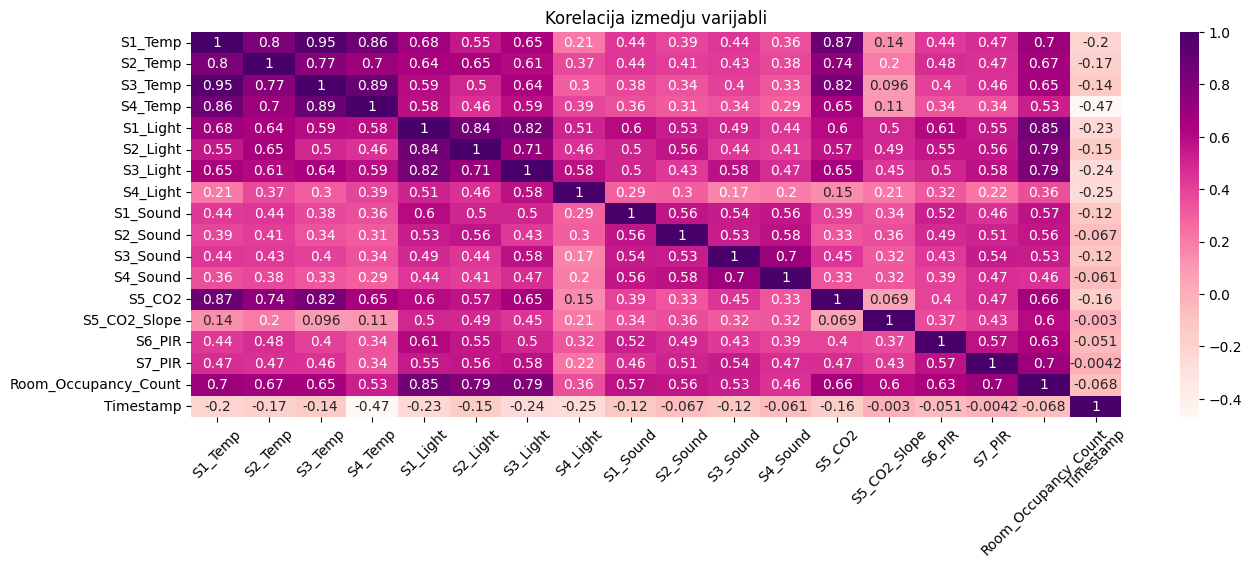

In [20]:
plt.subplots(figsize=(15,5))
correlation=data.corr()
sns.heatmap(correlation,annot=True,cmap='RdPu')
plt.title('Korelacija izmedju varijabli')
plt.xticks(rotation=45)

Mozemo primetiti da je veoma visoka korelacija izmedju S1_Temp i S3_Temp (0,95).
Uklonicemo S3_Temp.

In [23]:
data = data.drop(["S3_Temp"], axis=1)

In [24]:
data.columns

Index(['S1_Temp', 'S2_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light',
       'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2',
       'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count',
       'Timestamp'],
      dtype='object')

### Provera balansiranosti dataseta-a

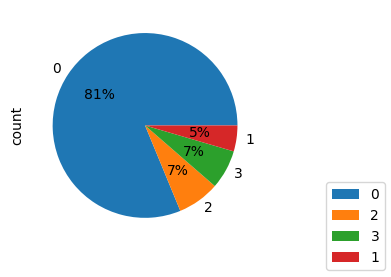

In [49]:
plt.figure(figsize=(5, 3))
pie = data.Room_Occupancy_Count.value_counts().plot(kind='pie', autopct='%1.0f%%')
pie.figure.set_size_inches(5, 3)
pie.figure.legend(loc='lower right')
plt.show()

Ovo su četiri klase kojima jedan uzorak može da pripada, a cilj projekta biće razvijanje modela koji podatak klasifikuje u jednu od ove četiri klase.Vidimo da je dataset nebalansiran.     
Zbog pojednostavljenja i radi bolje balansiranosti,prvo ćemo preći na ***binarnu klasifikaciju***,odnosno ostaje 0 (nema nikoga u prostoriji),i 1 (ima ljudi u prostoriji).

In [25]:
data['Room_Occupancy_Count'] = np.where(data['Room_Occupancy_Count'] == 0, 0, 1)

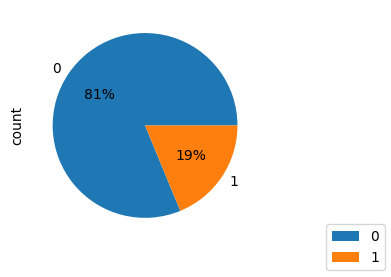

In [26]:
plt.figure(figsize=(5, 3))
pie = data.Room_Occupancy_Count.value_counts().plot(kind='pie', autopct='%1.0f%%')
pie.figure.set_size_inches(5, 3)
pie.figure.legend(loc='lower right')
plt.show()

Zatim delimo skup podataka na ulazne karakteristike modela i ciljnu promenljivu.

In [27]:
cols = [col for col in data.columns if col not in ['Room_Occupancy_Count']]
data_features = data[cols]
target = data['Room_Occupancy_Count']
data_features.head(10)

,S1_Temp,S2_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Timestamp
0,24.94,24.75,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1513939781
1,24.94,24.75,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1513939812
2,25.00,24.75,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1513939842
3,25.00,24.75,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1513939873
4,25.00,24.75,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1513939904
5,25.00,24.81,25.44,121,34,54,40,0.13,0.06,0.06,0.07,390,0.165385,0,0,1513939934
6,25.00,24.75,25.44,120,34,54,40,1.39,0.32,0.43,0.06,390,0.076923,1,0,1513939965
7,25.00,24.81,25.44,121,34,54,41,0.09,0.06,0.09,0.05,390,-0.011538,0,0,1513939995
8,25.00,24.81,25.50,122,35,56,43,0.09,0.05,0.06,0.13,390,-0.100000,0,0,1513940026
9,25.00,24.81,25.50,101,34,57,43,3.84,0.64,0.48,0.39,390,-0.188462,1,1,1513940057


In [28]:
data_train,data_test,target_train,target_test = train_test_split(data_features,target,test_size=0.3,random_state=10)

print(f"Broj uzoraka u trening skupu podataka: {len(data_train)}")
print(f"Broj uzoraka u test skupu podataka: {len(data_test)}")


Broj uzoraka u trening skupu podataka: 7090
Broj uzoraka u test skupu podataka: 3039


### Normalizacija atributa

In [29]:
scaler = preprocessing.StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

### Izbor algoritma cross validacije

In [30]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

### Balansiranje dataset-a

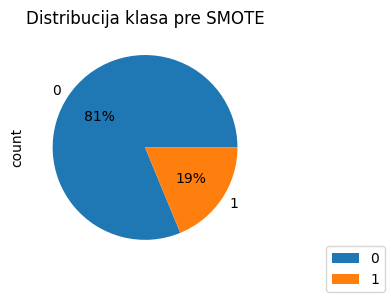

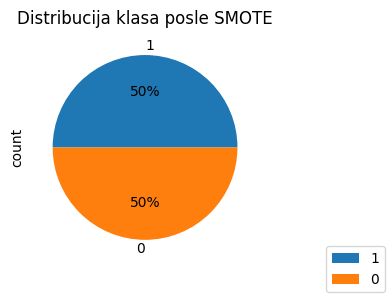

In [31]:
data_pre_smote = pd.DataFrame({'Class': target})
class_counts_pre_smote = data_pre_smote['Class'].value_counts()

plt.figure(figsize=(5, 3))
pie_pre_smote = class_counts_pre_smote.plot(kind='pie', autopct='%1.0f%%')
pie_pre_smote.figure.set_size_inches(5, 3)
pie_pre_smote.figure.legend(loc='lower right')
plt.title("Distribucija klasa pre SMOTE")
plt.show()

sm = SMOTE(random_state=2)
data_features_res, target_res = sm.fit_resample(data_features, target)

data_post_smote = pd.DataFrame({'Class': target_res})
class_counts_post_smote = data_post_smote['Class'].value_counts()

plt.figure(figsize=(5, 3))
pie_post_smote = class_counts_post_smote.plot(kind='pie', autopct='%1.0f%%')
pie_post_smote.figure.set_size_inches(5, 3)
pie_post_smote.figure.legend(loc='lower right')
plt.title("Distribucija klasa posle SMOTE")
plt.show()

In [32]:
data_train_balans, data_test_balans, target_train_balans, target_test_balans = train_test_split(data_features_res, target_res, test_size=0.3, random_state=10)

scaler = preprocessing.StandardScaler()
data_train_balanss = scaler.fit_transform(data_train_balans)
data_test_balanss = scaler.transform(data_test_balans)

print(f"Broj uzoraka u trening balansiranom skupu podataka: {len(data_train_balanss)}")
print(f"Broj uzoraka u test balansiranom skupu podataka: {len(data_test_balanss)}")

Broj uzoraka u trening balansiranom skupu podataka: 11519
Broj uzoraka u test balansiranom skupu podataka: 4937


### Funkcija za procenu uspešnosti

In [33]:
def eval_model(target_true_, target_pred_):
    accuracy = accuracy_score(target_true_, target_pred_)
    f1 = f1_score(target_true_, target_pred_)
    precision = precision_score(target_true_, target_pred_)
    recall = recall_score(target_true_, target_pred_)
    conf_matrix = confusion_matrix(y_true=target_true_, y_pred=target_pred_)
    TN, FP, FN, TP = conf_matrix.ravel()
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print("Accuracy : ", accuracy)
    print("F1 Score: ", f1)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Confuse matrix:")
    print(conf_matrix)
    print("True positive: ", TP)
    print("False positive: ", FP)
    print("True negative: ", TN)
    print("False negative: ", FN)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)

    return accuracy

In [34]:
def plot_conf_matrix(matrix):
    class_names=['N','P']

    dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

    sns.heatmap(dataframe, annot=True, cbar=None, fmt = ".1f", cmap="Blues")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

## Primena algoritama mašinskog učenja

### Linear SVC

__Bez cross validacije__

In [140]:
svc_model = LinearSVC(random_state=0)

svc=svc_model.fit(data_train, target_train)
pred=svc_model.predict(data_test)

svc_results_finished = eval_model(target_test,pred)

Accuracy :  0.9993418887792037
F1 Score:  0.9982788296041308
Precision:  0.9982788296041308
Recall:  0.9982788296041308
Confuse matrix:
[[2457    1]
 [   1  580]]
True positive:  580
False positive:  1
True negative:  2457
False negative:  1
Sensitivity:  0.9982788296041308
Specificity:  0.999593165174939


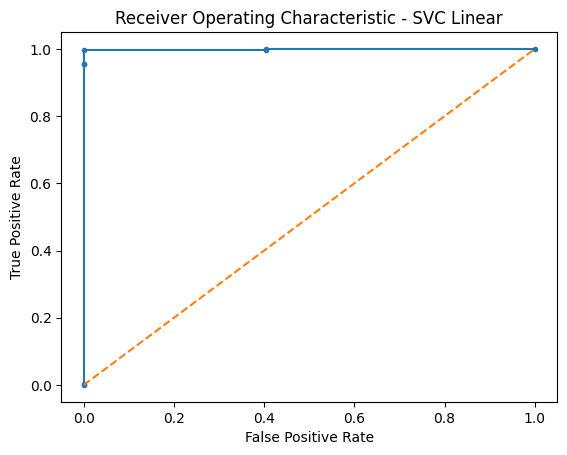

In [141]:
pred = svc.decision_function(data_test) 
fpr, tpr, _ = roc_curve(target_test, pred)
plt.title("Receiver Operating Characteristic - SVC Linear")
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

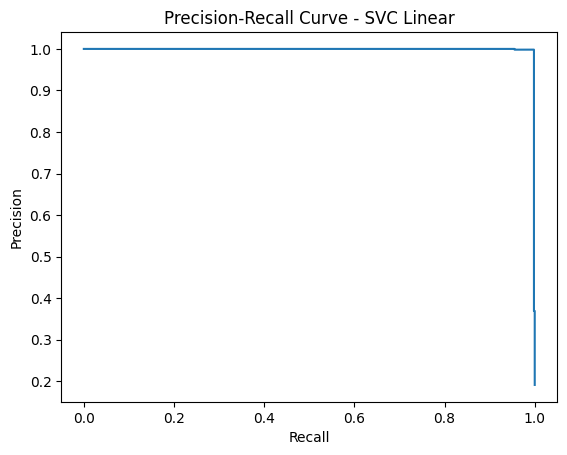

PR AUC=0.9988389228


In [144]:
target_scores = svc.decision_function(data_test)

precision, recall, _ = precision_recall_curve(target_test, target_scores)

plt.title("Precision-Recall Curve - SVC Linear")
plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

pr_auc = average_precision_score(target_test, target_scores)
print('PR AUC=%.10f' % pr_auc)

__Sa cross validacijom__

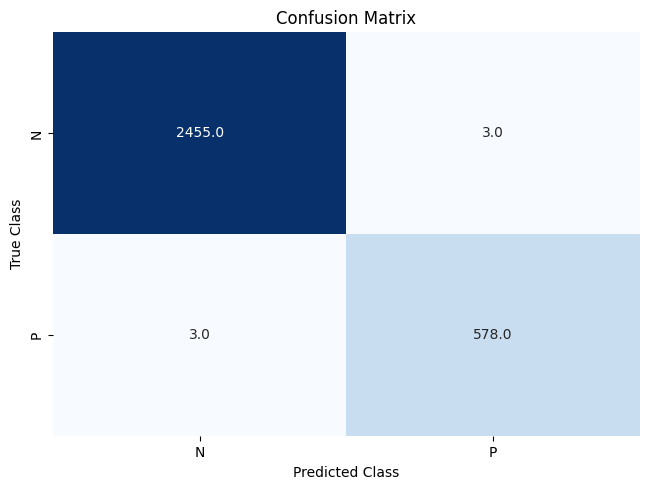

Average Accuracy:  0.9993089832181639
Average F1 Score:  0.998117822050436
Average ROC AUC:  0.998969038590882


In [127]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
svc_model = LinearSVC(random_state=0)
pipeline = make_pipeline(StandardScaler(), svc_model)
cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

__Sa balansiranim skupom podataka + cross validacija__

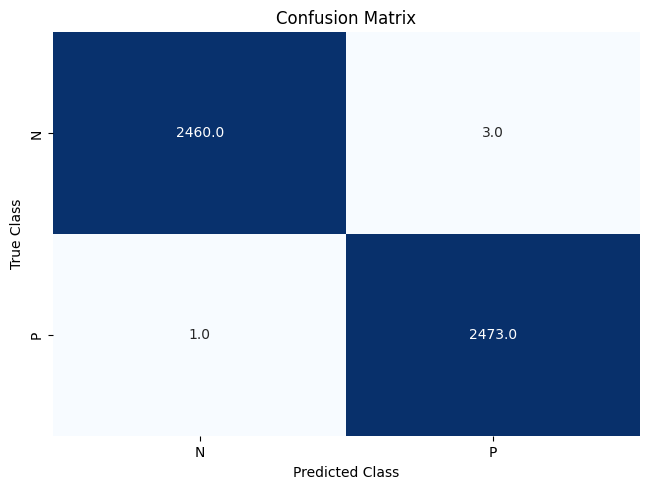

Average Accuracy:  0.9995139363364073
Average F1 Score:  0.999510980828241
Average ROC AUC:  0.9995269994288991


In [131]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
svc_model = LinearSVC(random_state=0)
pipeline = make_pipeline(StandardScaler(), svc_model)
cv_results = cross_validate(pipeline, data_features_res, target_res, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test_balanss, target_test_balans, cv=kfold)

conf_mat_cv = confusion_matrix(target_test_balans, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### KNeighbors klasifikator

__Bez cross validacije__

In [145]:
nearest_neighbors = KNeighborsClassifier(n_neighbors=3)

kn=nearest_neighbors.fit(data_train, target_train)
pred=nearest_neighbors.predict(data_test)

kn_results_finished = eval_model(target_test,pred)

Accuracy :  0.9976966107272129
F1 Score:  0.9940017137960582
Precision:  0.9897610921501706
Recall:  0.9982788296041308
Confuse matrix:
[[2452    6]
 [   1  580]]
True positive:  580
False positive:  6
True negative:  2452
False negative:  1
Sensitivity:  0.9982788296041308
Specificity:  0.9975589910496339


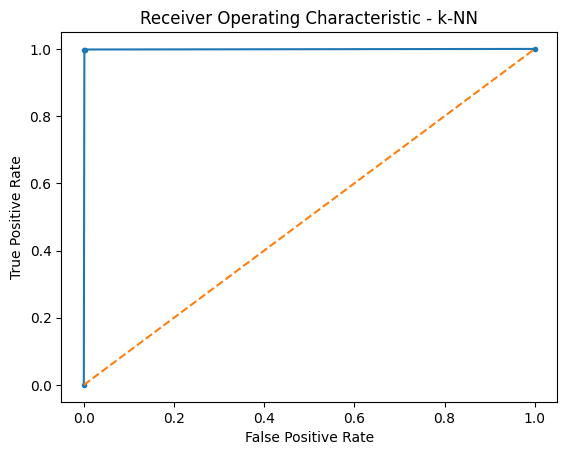

In [147]:
target_probabilities = nearest_neighbors.predict_proba(data_test)[:, 1]

fpr, tpr, _ = roc_curve(target_test, target_probabilities)

plt.title("Receiver Operating Characteristic - k-NN")
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

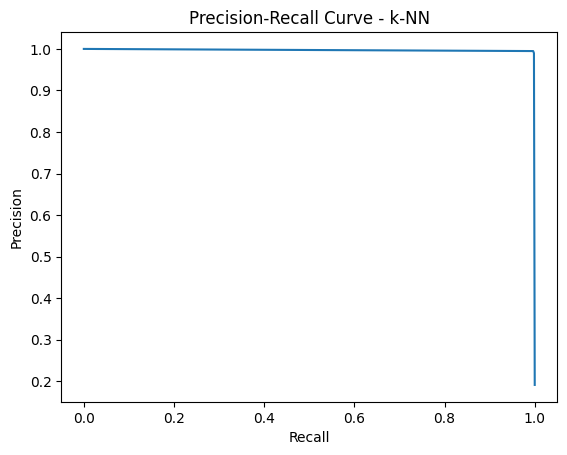

PR AUC=0.9934533672


In [148]:
target_probabilities = nearest_neighbors.predict_proba(data_test)[:, 1]

precision, recall, _ = precision_recall_curve(target_test, target_probabilities)

plt.title("Precision-Recall Curve - k-NN")
plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

pr_auc = average_precision_score(target_test, target_probabilities)
print('PR AUC=%.10f' % pr_auc)

__Sa cross validacijom__

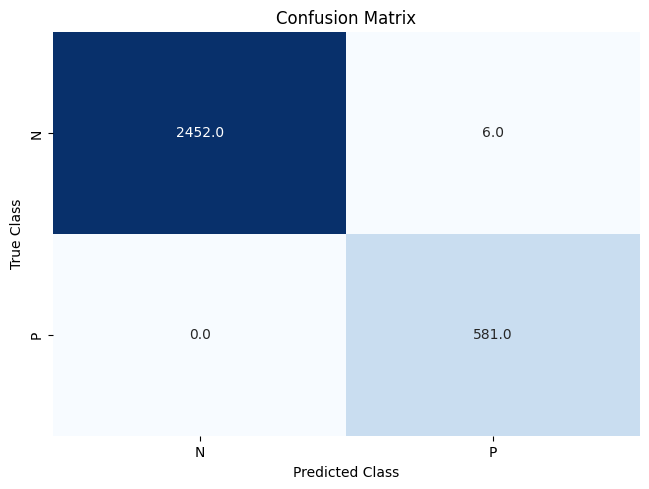

Average Accuracy:  0.9985191522070787
Average F1 Score:  0.9960217729679384
Average ROC AUC:  0.9988795412777638


In [125]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
nearest_neighbors = KNeighborsClassifier(n_neighbors=3)
pipeline = make_pipeline(StandardScaler(), nearest_neighbors)
cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

__Sa balansiranim skupom podataka + cross validacija__

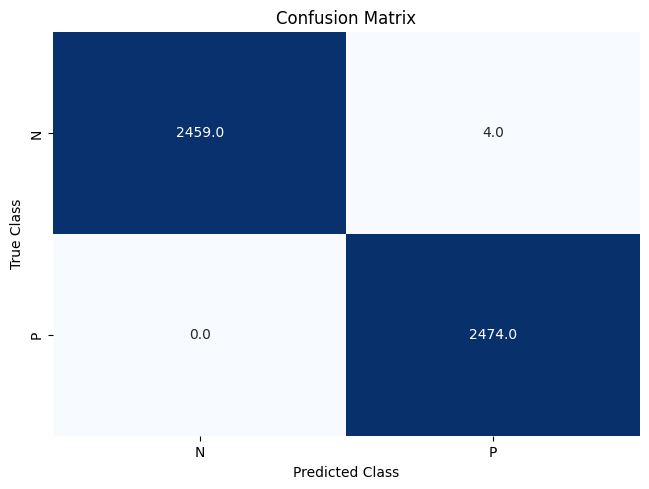

Average Accuracy:  0.9990885890821257
Average F1 Score:  0.9990821756559114
Average ROC AUC:  0.9990989172947667


In [124]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
nearest_neighbors = KNeighborsClassifier(n_neighbors=3)
pipeline = make_pipeline(StandardScaler(), nearest_neighbors)
cv_results = cross_validate(pipeline, data_features_res, target_res, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test_balanss, target_test_balans, cv=kfold)

conf_mat_cv = confusion_matrix(target_test_balans, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### Naive Bayes

__Bez cross validacije__

In [149]:
naive_bayes = GaussianNB()

naive_bayes.fit(data_train, target_train)
pred=naive_bayes.predict(data_test)

nb_results_finished = eval_model(target_test,pred)

Accuracy :  0.983218163869694
F1 Score:  0.9576059850374065
Precision:  0.9260450160771704
Recall:  0.9913941480206541
Confuse matrix:
[[2412   46]
 [   5  576]]
True positive:  576
False positive:  46
True negative:  2412
False negative:  5
Sensitivity:  0.9913941480206541
Specificity:  0.9812855980471928


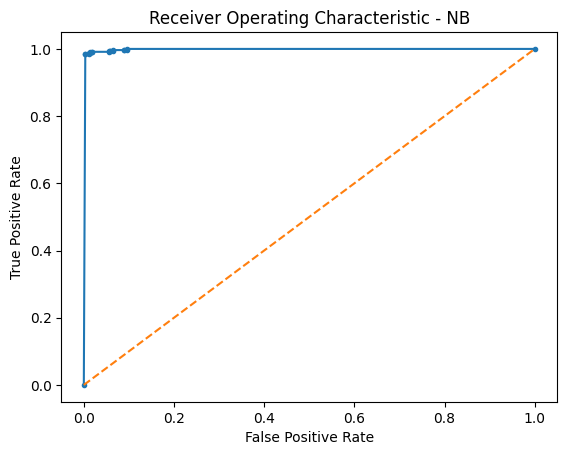

In [153]:
target_probabilities = naive_bayes.predict_proba(data_test)[:, 1]

fpr, tpr, _ = roc_curve(target_test, target_probabilities)

plt.title("Receiver Operating Characteristic - NB")
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

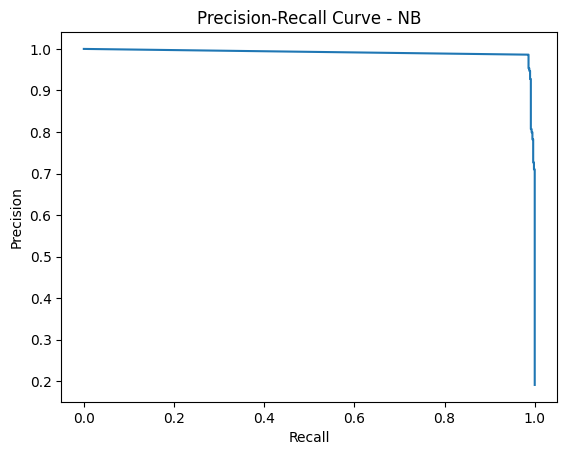

PR AUC=0.9840806196


In [152]:
target_probabilities = naive_bayes.predict_proba(data_test)[:, 1]

precision, recall, _ = precision_recall_curve(target_test, target_probabilities)

plt.title("Precision-Recall Curve - NB")
plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

pr_auc = average_precision_score(target_test, target_probabilities)
print('PR AUC=%.10f' % pr_auc)

__Sa cross validacijom__

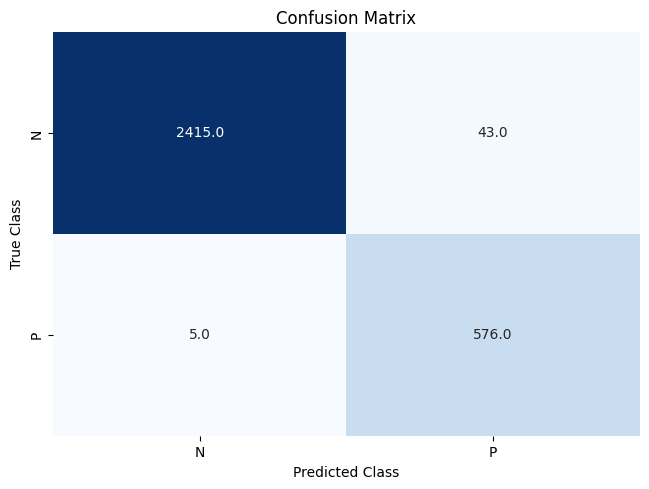

Average Accuracy:  0.9822293387542969
Average F1 Score:  0.9542336937641493
Average ROC AUC:  0.9840500377048625


In [123]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
naive_bayes = GaussianNB()
pipeline = make_pipeline(StandardScaler(), naive_bayes)
cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

__Balansirani skup podataka + cross validacija__

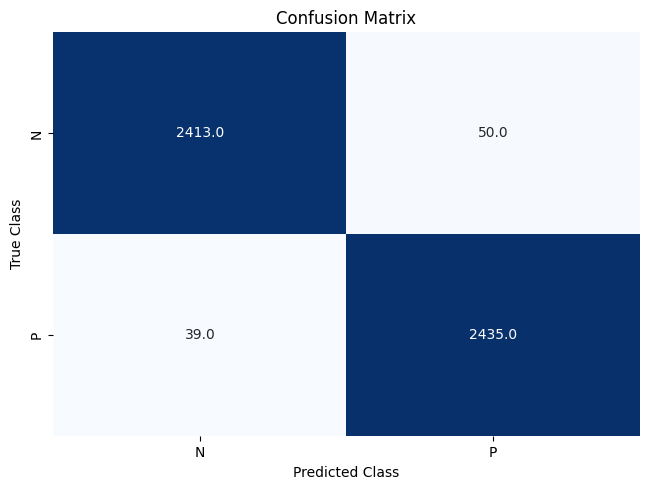

Average Accuracy:  0.9790351483009376
Average F1 Score:  0.9790043921347997
Average ROC AUC:  0.9790489779671508


In [122]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
naive_bayes = GaussianNB()
pipeline = make_pipeline(StandardScaler(), naive_bayes)
cv_results = cross_validate(pipeline, data_features_res, target_res, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test_balanss, target_test_balans, cv=kfold)

conf_mat_cv = confusion_matrix(target_test_balans, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### Logistic Regression

__Bez cross validacije__

In [155]:
log_reg = LogisticRegression()

log_reg.fit(data_train, target_train)
pred=log_reg.predict(data_test)

lg_results_finished = eval_model(target_test,pred)

Accuracy :  0.9986837775584074
F1 Score:  0.9965576592082617
Precision:  0.9965576592082617
Recall:  0.9965576592082617
Confuse matrix:
[[2456    2]
 [   2  579]]
True positive:  579
False positive:  2
True negative:  2456
False negative:  2
Sensitivity:  0.9965576592082617
Specificity:  0.9991863303498779


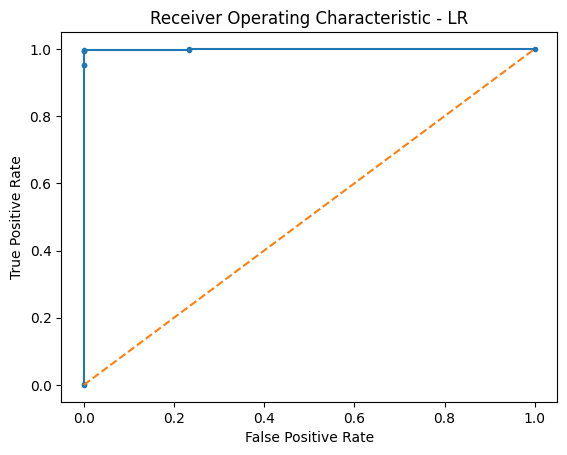

In [156]:
target_probabilities = log_reg.predict_proba(data_test)[:, 1]

fpr, tpr, _ = roc_curve(target_test, target_probabilities)

plt.title("Receiver Operating Characteristic - LR")
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

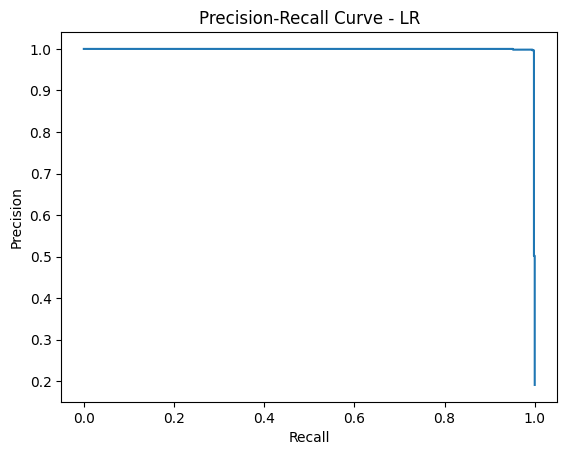

PR AUC=0.9990553927


In [157]:
target_probabilities = log_reg.predict_proba(data_test)[:, 1]

precision, recall, _ = precision_recall_curve(target_test, target_probabilities)

plt.title("Precision-Recall Curve - LR")
plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

pr_auc = average_precision_score(target_test, target_probabilities)
print('PR AUC=%.10f' % pr_auc)

__Sa cross validacijom__

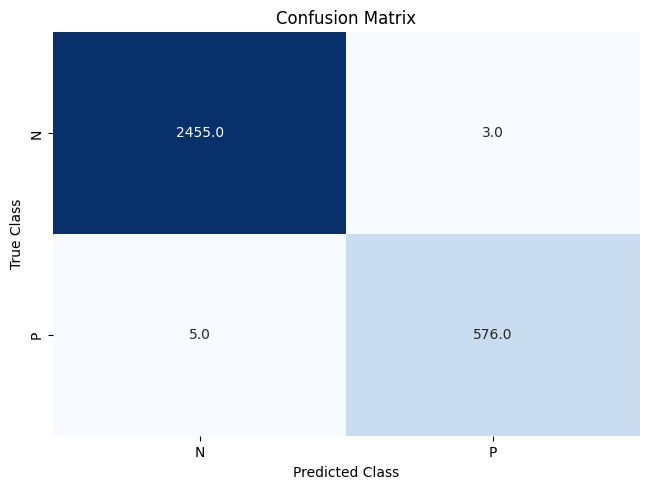

Average Accuracy:  0.9987166831194472
Average F1 Score:  0.9965621928997377
Average ROC AUC:  0.9978179193968444


In [38]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
log_reg = LogisticRegression()
pipeline = make_pipeline(StandardScaler(), log_reg)
cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

__Balansirani skup podataka + cross validacija__

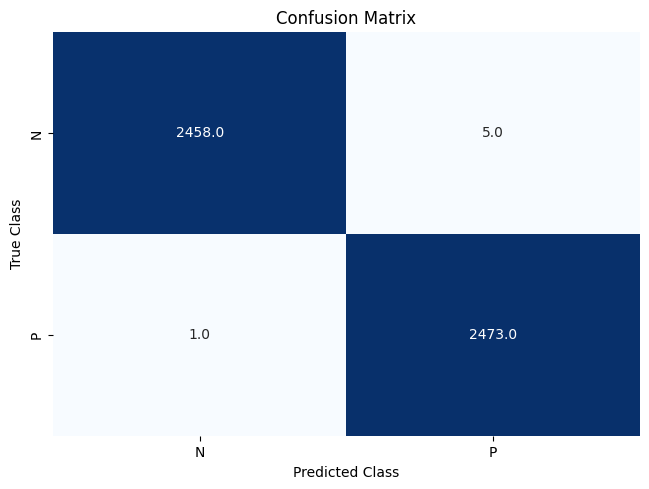

Average Accuracy:  0.9993923927214172
Average F1 Score:  0.9993898610864929
Average ROC AUC:  0.9994049894181266


In [120]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
log_reg = LogisticRegression()
pipeline = make_pipeline(StandardScaler(), log_reg)
cv_results = cross_validate(pipeline, data_features_res, target_res, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test_balanss, target_test_balans, cv=kfold)

conf_mat_cv = confusion_matrix(target_test_balans, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### Decision Tree

__Bez cross validacije__

In [161]:
decisionTree = DecisionTreeClassifier()

decisionTree.fit(data_train, target_train)
pred=decisionTree.predict(data_test)

dc_results_finished = eval_model(target_test,pred)

Accuracy :  0.9990128331688055
F1 Score:  0.9974160206718347
Precision:  0.9982758620689656
Recall:  0.9965576592082617
Confuse matrix:
[[2457    1]
 [   2  579]]
True positive:  579
False positive:  1
True negative:  2457
False negative:  2
Sensitivity:  0.9965576592082617
Specificity:  0.999593165174939


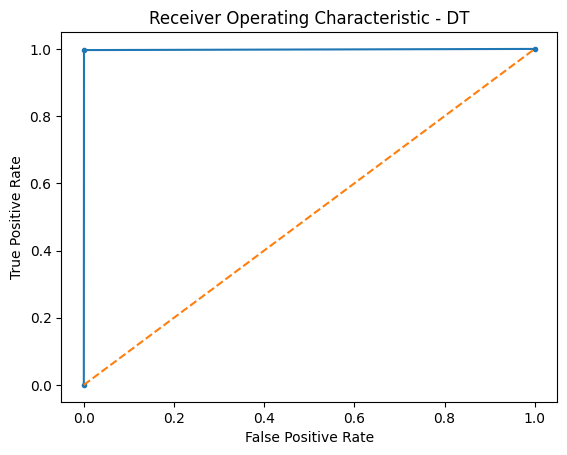

In [162]:
target_probabilities = decisionTree.predict_proba(data_test)[:, 1]

fpr, tpr, _ = roc_curve(target_test, target_probabilities)

plt.title("Receiver Operating Characteristic - DT")
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

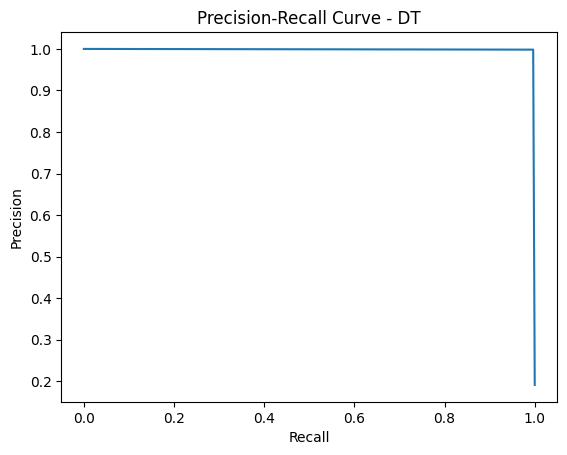

PR AUC=0.9954975676


In [163]:
target_probabilities = decisionTree.predict_proba(data_test)[:, 1]

precision, recall, _ = precision_recall_curve(target_test, target_probabilities)

plt.title("Precision-Recall Curve - DT")
plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

pr_auc = average_precision_score(target_test, target_probabilities)
print('PR AUC=%.10f' % pr_auc)

__Sa cross validacijom__

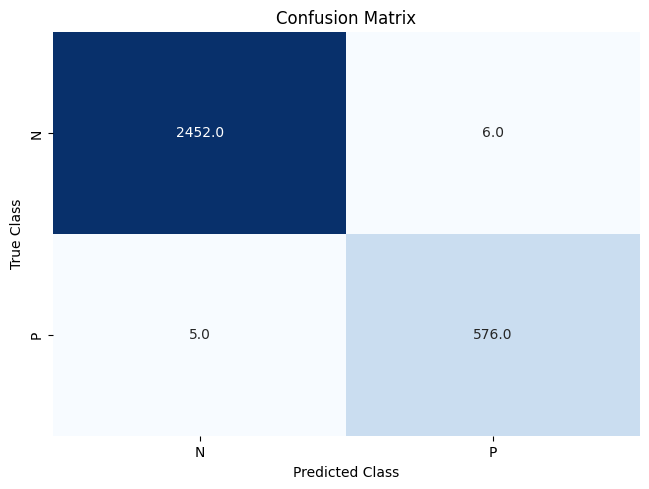

Average Accuracy:  0.9992102665350444
Average F1 Score:  0.9978954358160781
Average ROC AUC:  0.9987404404626525


In [118]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
decisionTree = DecisionTreeClassifier()
pipeline = make_pipeline(StandardScaler(), decisionTree)
cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

__Balansirani skup podataka + cross validacija__

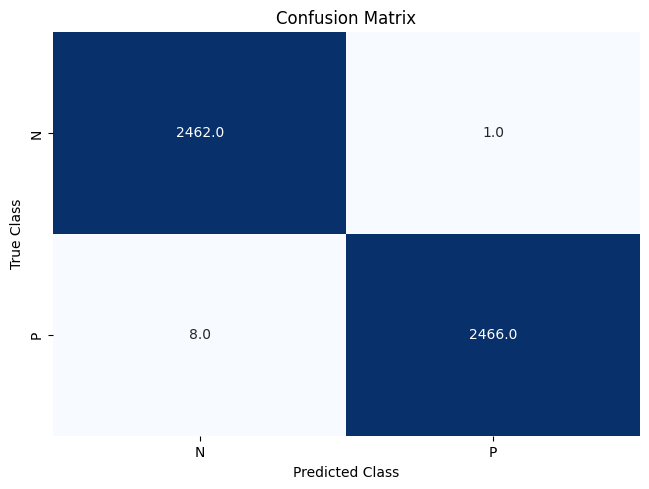

Average Accuracy:  0.9992099480365038
Average F1 Score:  0.9992221006849166
Average ROC AUC:  0.9992189933241592


In [119]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
decisionTree = DecisionTreeClassifier()
pipeline = make_pipeline(StandardScaler(), decisionTree)
cv_results = cross_validate(pipeline, data_features_res, target_res, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test_balanss, target_test_balans, cv=kfold)

conf_mat_cv = confusion_matrix(target_test_balans, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### Random Forest

__Bez cross validacije__

In [164]:
randomForest = RandomForestClassifier(random_state=0, criterion="entropy") 

rfModel=randomForest.fit(data_train, target_train)
pred=randomForest.predict(data_test)

rf_results_finished = eval_model(target_test,pred)


Accuracy :  0.9993418887792037
F1 Score:  0.9982788296041308
Precision:  0.9982788296041308
Recall:  0.9982788296041308
Confuse matrix:
[[2457    1]
 [   1  580]]
True positive:  580
False positive:  1
True negative:  2457
False negative:  1
Sensitivity:  0.9982788296041308
Specificity:  0.999593165174939


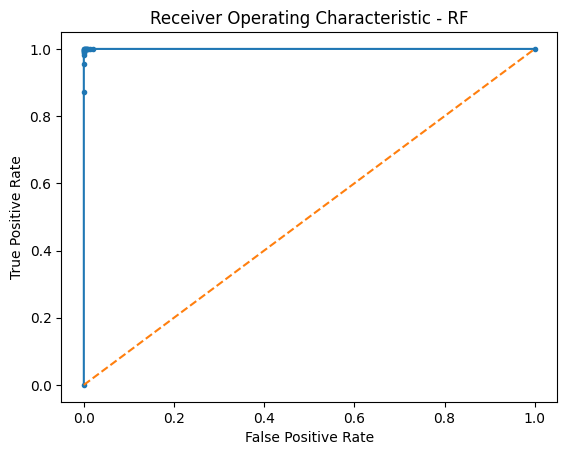

In [165]:
target_probabilities = randomForest.predict_proba(data_test)[:, 1]

fpr, tpr, _ = roc_curve(target_test, target_probabilities)

plt.title("Receiver Operating Characteristic - RF")
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

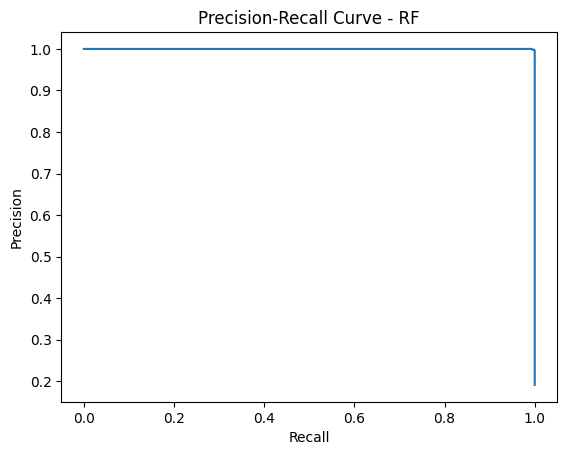

PR AUC=0.9999851928


In [166]:
target_probabilities = randomForest.predict_proba(data_test)[:, 1]

precision, recall, _ = precision_recall_curve(target_test, target_probabilities)

plt.title("Precision-Recall Curve - RF")
plt.plot(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

pr_auc = average_precision_score(target_test, target_probabilities)
print('PR AUC=%.10f' % pr_auc)

__Sa cross validacijom__

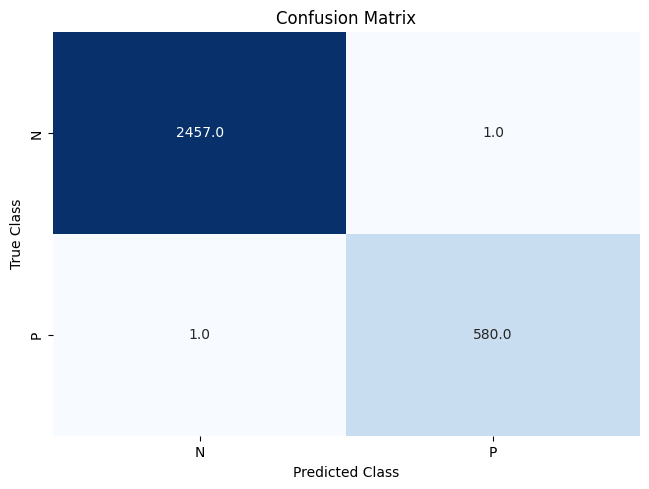

Average Accuracy:  0.9998025666337611
Average F1 Score:  0.9994507189562155
Average ROC AUC:  0.9996800595238096


In [129]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
randomForest = RandomForestClassifier(random_state=0, criterion="entropy") 
pipeline = make_pipeline(StandardScaler(), randomForest)
cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

__Sa balansiranim skupom podataka + cross validacija__

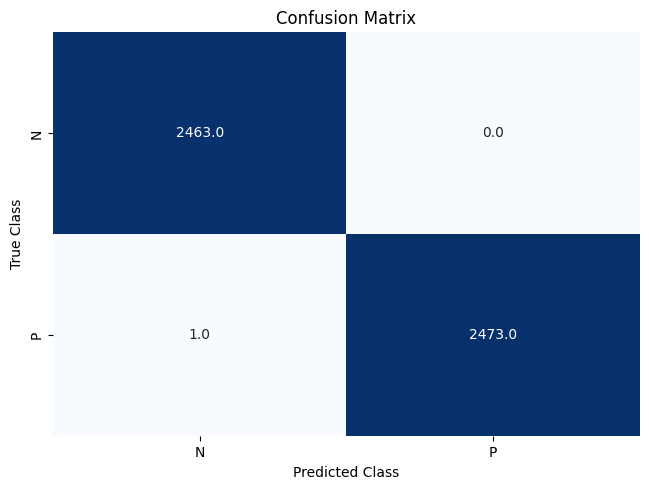

Average Accuracy:  0.9998784933171324
Average F1 Score:  0.9998819062451311
Average ROC AUC:  0.9998804273757024


In [130]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
randomForest = RandomForestClassifier(random_state=0, criterion="entropy") 
pipeline = make_pipeline(StandardScaler(), randomForest)
cv_results = cross_validate(pipeline, data_features_res, target_res, cv=kfold, scoring=scoring,n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test_balanss, target_test_balans, cv=kfold)

conf_mat_cv = confusion_matrix(target_test_balans, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

#### Optimizacija Random Forest modela izborom relevantnih atributa

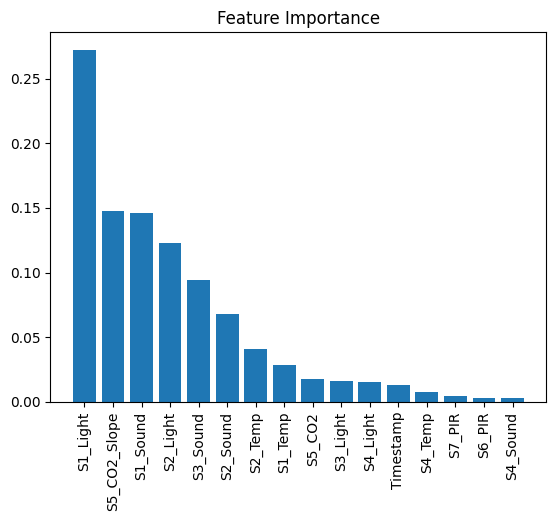

In [135]:
randomForest = RandomForestClassifier(random_state=0, criterion="entropy")
importances = rfModel.feature_importances_
indices = np.argsort(importances)[::-1]
names = [data_features.columns[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(data_train.shape[1]), importances[indices])
plt.xticks(range(data_train.shape[1]), names, rotation=90)
plt.show()

Sledeći deo koda selektuje atribute koji imaju značaj veći od 0,025 i trenira novi model nad transformisanim skupom podataka

In [136]:
def selectFeaturesRF(th):
    selector = SelectFromModel(randomForest, threshold=th) 

    features_important = selector.fit_transform(data_train, target_train)

    test_important = selector.transform(data_test)

    randomForestModel = randomForest.fit(features_important,target_train)

    predRFC = randomForestModel.predict(test_important)

    print("RandomForest accuracy : ",accuracy_score(target_test, predRFC, normalize = True))
    print(confusion_matrix(target_test, predRFC))

selectFeaturesRF(0.025)


RandomForest accuracy :  0.9993418887792037
[[2457    1]
 [   1  580]]


## Ensemble metode

Ensemble metode u klasifikaciji su tehnike koje kombinuju više modela za poboljšanje ukupne prediktivne sposobnosti sistema.Neke od uobičajenih ensemble metoda u klasifikaciji su:     
1. Bagging  
2. Boosting    
3. Stacking    
4. Voting    


### Bagging

Kod Bagging metode kombinuje se više modela iste vrste kako bi se došlo do klasifikacije.

__Naive Bayes__

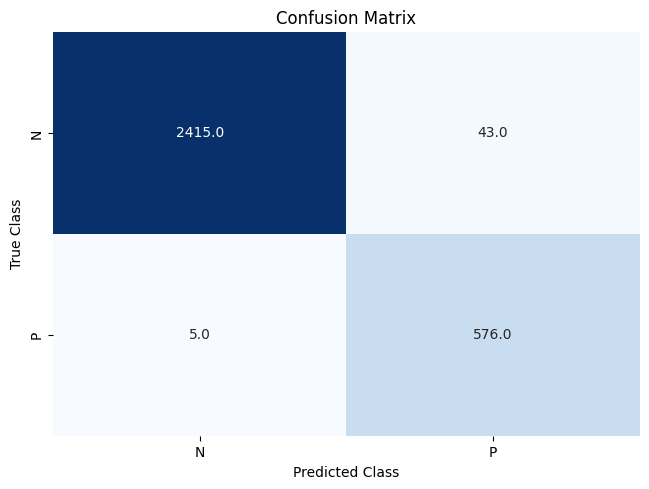

Average Accuracy:  0.9826242054867746
Average F1 Score:  0.955213781886189
Average ROC AUC:  0.9974415214100609


In [43]:
naive_bayes = GaussianNB()
bagging_naive_bayes = BaggingClassifier(naive_bayes, n_estimators=10, random_state=42, n_jobs=-1)
pipeline = make_pipeline(StandardScaler(), bagging_naive_bayes)

cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))


__Logistic Regression__

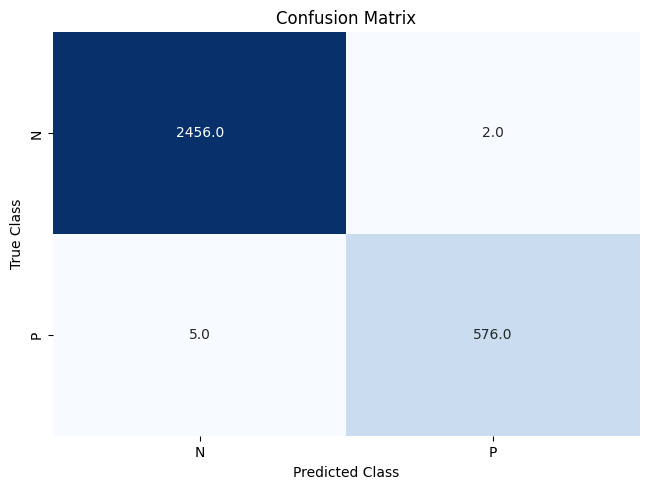

Average Accuracy:  0.9987165855733176
Average F1 Score:  0.9965581972054254
Average ROC AUC:  0.9998611683101123


In [44]:
lg = LogisticRegression()
bagging_lg = BaggingClassifier(lg, n_estimators=10, random_state=42, n_jobs=-1)
pipeline = make_pipeline(StandardScaler(), bagging_lg)

cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

__Decision Tree__

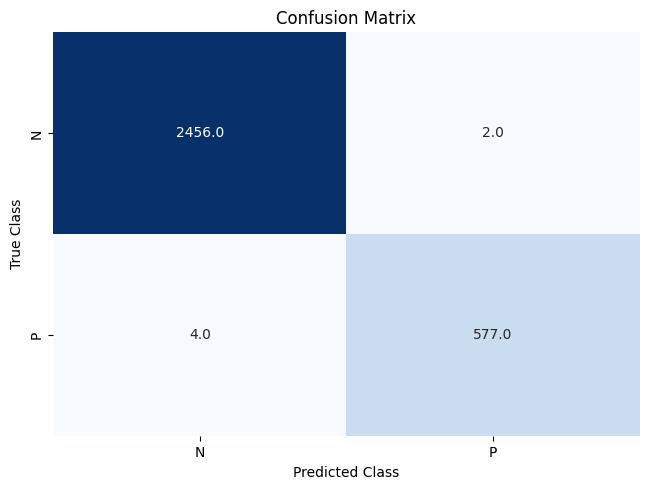

Average Accuracy:  0.9992100714427853
Average F1 Score:  0.9978940373699482
Average ROC AUC:  0.9994344472282058


In [45]:
decisionTree = DecisionTreeClassifier()
bagging_decisionTree = BaggingClassifier(decisionTree, n_estimators=10, random_state=42, n_jobs=-1)
pipeline = make_pipeline(StandardScaler(), bagging_decisionTree)

cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)

target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### Boosting

#### XGBoost

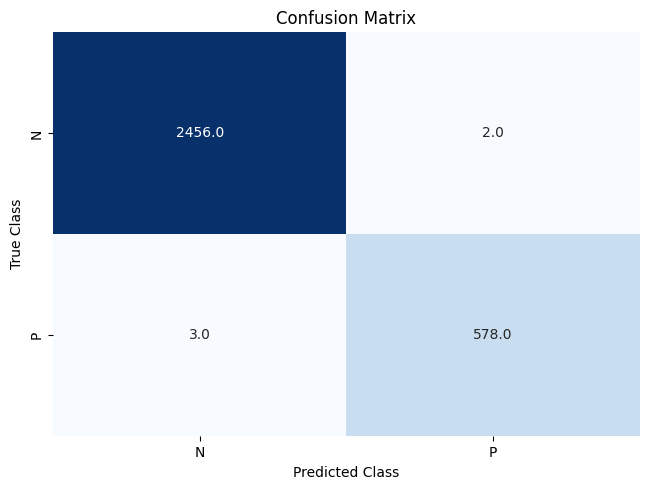

Average Accuracy:  0.9991114523057953
Average F1 Score:  0.9976861977308407
Average ROC AUC:  0.998091978675103


In [47]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
xgboost_model = XGBClassifier(random_state=0, objective='binary:logistic', eval_metric='logloss')

pipeline = make_pipeline(StandardScaler(), xgboost_model)
cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring, n_jobs=-1)
target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

#### Ada Boost

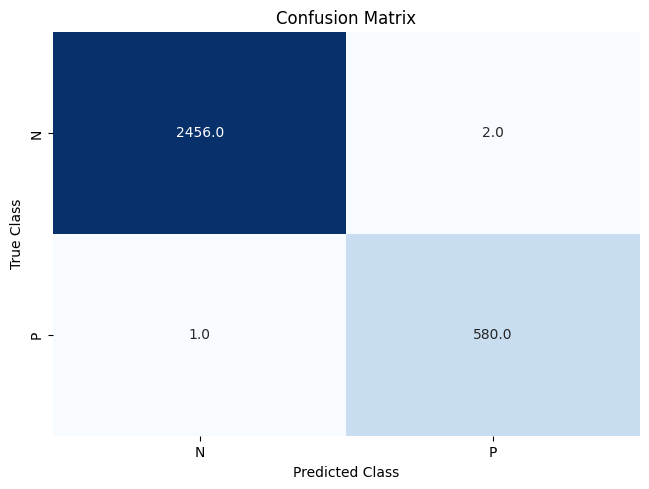

Average Accuracy:  0.9996050357213926
Average F1 Score:  0.9989271264537312
Average ROC AUC:  0.9993603125546461


In [48]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}
base_model = DecisionTreeClassifier(max_depth=1, random_state=0)

adaboost_model = AdaBoostClassifier(base_model, n_estimators=50, random_state=0)
pipeline = make_pipeline(StandardScaler(), adaboost_model)

cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring, n_jobs=-1)
target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

#### Gradient Boosting

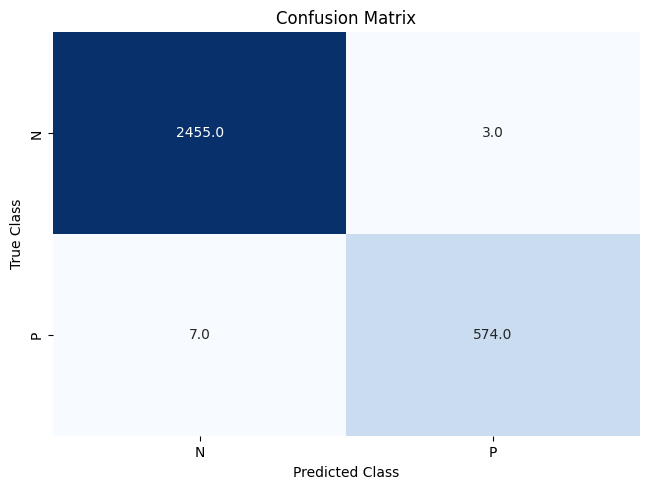

Average Accuracy:  0.9989138238472973
Average F1 Score:  0.9971234119812834
Average ROC AUC:  0.9977672904858046


In [52]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}

gradient_boost_model = GradientBoostingClassifier(n_estimators=50, random_state=0)
pipeline = make_pipeline(StandardScaler(), gradient_boost_model)

cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring, n_jobs=-1)
target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### Stacking

Stacking tehnika kombinuje više klasifikatora tako što se dataset deli u više delova i svaki klasifikator se trenira posebno na delovima dataset-a. Rezultat fittovanja svakog klasifikatora se koristi da se napravi konačni model klasifikacije.

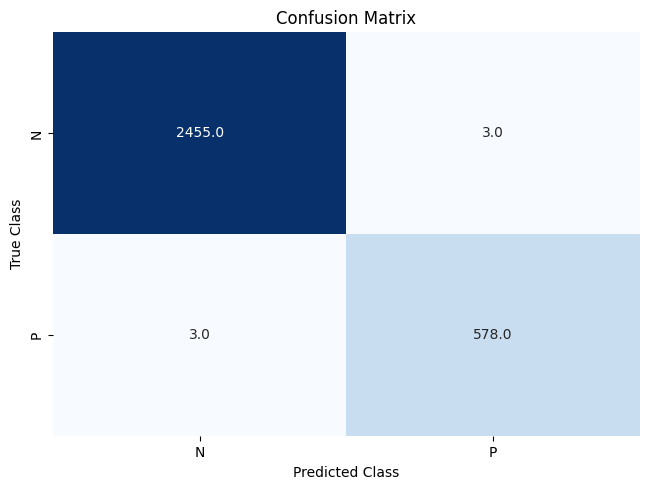

Average Accuracy:  0.9995064165844028
Average F1 Score:  0.9986546504218495
Average ROC AUC:  0.9992867394418947


In [56]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}

svc = SVC(probability=True, random_state=0)
decisionTree = DecisionTreeClassifier(random_state=0)
randomForest = RandomForestClassifier(random_state=0, criterion="entropy")
knn = KNeighborsClassifier()
lb=LogisticRegression()

stacking_classifier = StackingClassifier(
    estimators=[
        ('svc', svc),
        ('dt', decisionTree),
        ('rf', randomForest),
        ('knn', knn),
        ('lb',lb)
    ],
    cv=kfold,
    stack_method='predict_proba', 
    n_jobs=-1
)

pipeline = make_pipeline(StandardScaler(), stacking_classifier)

cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring, n_jobs=-1)
target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

### Voting

Voting je tehnika kojom se kombinuje više raznovrsnih klasifikatora koji zajedno "glasaju" o konačnom rezultatu klasifikacije.

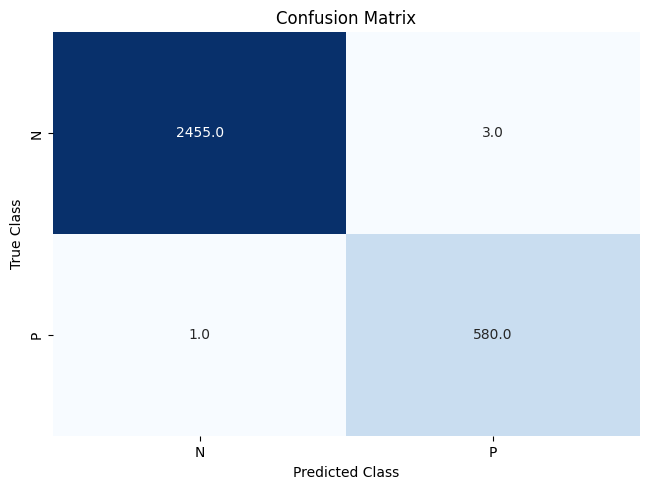

Average Accuracy:  0.9992102665350444
Average F1 Score:  0.997857918134579
Average ROC AUC:  0.9991049662436179


In [58]:
scoring = {'accuracy': 'accuracy', 'f1': make_scorer(f1_score), 'roc_auc': make_scorer(roc_auc_score)}

svc = SVC(probability=True, random_state=0)
decisionTree = DecisionTreeClassifier(random_state=0)
randomForest = RandomForestClassifier(random_state=0, criterion="entropy")
knn = KNeighborsClassifier()
lb = LogisticRegression()

voting_classifier = VotingClassifier(
    estimators=[
        ('svc', svc),
        ('dt', decisionTree),
        ('rf', randomForest),
        ('knn', knn),
        ('lb', lb)
    ],
    voting='soft'  
)

pipeline = make_pipeline(StandardScaler(), voting_classifier)

cv_results = cross_validate(pipeline, data_features, target, cv=kfold, scoring=scoring, n_jobs=-1)
target_pred_cv = cross_val_predict(pipeline, data_test, target_test, cv=kfold)

conf_mat_cv = confusion_matrix(target_test, target_pred_cv)
plot_conf_matrix(conf_mat_cv)

print("Average Accuracy: ", np.mean(cv_results['test_accuracy']))
print("Average F1 Score: ", np.mean(cv_results['test_f1']))
print("Average ROC AUC: ", np.mean(cv_results['test_roc_auc']))

## Podesavanje hiperparametara SUBOTA

## Redukcija dimenzionalnosti NEDELJA

### PCA

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

pca = PCA(n_components=0.99)
scaler = preprocessing.StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

def PCA_selection(model,modelName,test=False):
    pipe = Pipeline(steps=[('pca', pca),
                           ('model', model)])
    model = pipe.fit(data_train,target_train)
    prediction = model.predict(data_test)
    print(f"Best {modelName} accuracy : ",accuracy_score(target_test, prediction, normalize = True))
    if(test):
        print(model[1].n_features_in_)

svc = SVC(C=166.81005372000593, gamma=1,probability=True)
decisionTree = DecisionTreeClassifier(ccp_alpha=0, class_weight='balanced',
                       criterion='entropy', max_depth=21, min_samples_split=6,
                       random_state=0)
randomForest = RandomForestClassifier(criterion='entropy', max_depth=80, max_features='sqrt',
                       min_samples_split=7, n_estimators=2000, random_state=0)
knn=KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')
naive_bayes = GaussianNB()
xgb_model = XGBClassifier(n_estimators=100)
adaboost_model = AdaBoostClassifier(n_estimators=100)

PCA_selection(svc,"SVC",True)
PCA_selection(decisionTree,"Decision Tree")
PCA_selection(randomForest,"Random Forest")
PCA_selection(knn,"KNeighbors")
PCA_selection(naive_bayes,"Naive Bayes")
PCA_selection(adaboost_model, "AdaBoost")
PCA_selection(xgb_model, "XGBoost")

Best SVC accuracy :  0.9693978282329714
14
Best Decision Tree accuracy :  0.9861796643632774
Best Random Forest accuracy :  0.9906219151036525
Best KNeighbors accuracy :  0.9906219151036525
Best Naive Bayes accuracy :  0.9461994076999013
Best AdaBoost accuracy :  0.7527147087857848
Best XGBoost accuracy :  0.9911154985192497


### VarianceThreshold

In [148]:
from sklearn.feature_selection import VarianceThreshold

print(data.var())

data_train_VT,data_test_VT,target_train_VT,target_test_VT = train_test_split(data_features,target,test_size=0.2,random_state=10)

scaler = preprocessing.StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)
thresholder = VarianceThreshold(threshold=.5)
data_train_VT = thresholder.fit_transform(data_train_VT)
data_test_VT = thresholder.transform(data_test_VT)

print("\nColumn number: ", len(data_train_VT[0]),"\n")

scaler = preprocessing.StandardScaler()
data_train_VT = scaler.fit_transform(data_train_VT)
data_test_VT = scaler.transform(data_test_VT)

def VT_selection(model,modelName):
    modelTrained = model.fit(data_train_VT,target_train)
    prediction = modelTrained.predict(data_test_VT)
    print(f"Best {modelName} accuracy : ",accuracy_score(target_test, prediction, normalize = True))

VT_selection(svc,"SVC")
VT_selection(decisionTree,"Decision Tree")
VT_selection(randomForest,"Random Forest")
VT_selection(knn,"KNeighbors")
VT_selection(naive_bayes,"Naive Bayes")
VT_selection(adaboost_model, "AdaBoost")
VT_selection(xgb_model, "XGBoost")


S1_Temp                           0.12
S2_Temp                           0.34
S4_Temp                           0.13
S1_Light                       2602.15
S2_Light                       4529.85
S3_Light                       3410.65
S4_Light                        384.25
S1_Sound                          0.10
S2_Sound                          0.07
S3_Sound                          0.17
S4_Sound                          0.01
S5_CO2                        39985.98
S5_CO2_Slope                      1.36
S6_PIR                            0.08
S7_PIR                            0.07
Room_Occupancy_Count              0.80
Timestamp              388036766520.45
dtype: float64

Column number:  7 

Best SVC accuracy :  0.9930898321816387
Best Decision Tree accuracy :  0.9960513326752222
Best Random Forest accuracy :  0.9930898321816387
Best KNeighbors accuracy :  0.9940769990128332
Best Naive Bayes accuracy :  0.9215202369200395
Best AdaBoost accuracy :  0.8321816386969397
Best XGBoost accuracy

### SelectPercentile

In [149]:

from sklearn.feature_selection import f_classif,VarianceThreshold,SelectKBest,SelectPercentile

f_classif_selector = SelectPercentile(f_classif, percentile=90)
data_features_selectP = f_classif_selector.fit_transform(data_features, target)
# Show results
print("Original number of features:", data_train.shape[1])
print("Reduced number of features:", data_features_selectP.shape[1])

print(data_features.columns)
print(data_features.head(1))
print(data_features_selectP[0],"\n")

data_train_selectP,data_test_selectP,target_train_selectP,target_test_selectP = train_test_split(data_features_selectP,target,test_size=0.2,random_state=10)

scaler = preprocessing.StandardScaler()

data_train_selectP = scaler.fit_transform(data_train_selectP)
data_test_selectP = scaler.transform(data_test_selectP)

def SelectP_selection(model,modelName):
    modelTrained = model.fit(data_train_selectP,target_train_selectP)
    prediction = modelTrained.predict(data_test_selectP)
    print(f"Best {modelName} accuracy : ",accuracy_score(target_test_selectP, prediction, normalize = True))


SelectP_selection(svc,"SVC")
SelectP_selection(decisionTree,"Decision Tree")
SelectP_selection(randomForest,"Random Forest")
SelectP_selection(knn,"KNeighbors")
SelectP_selection(naive_bayes,"Naive Bayes")
SelectP_selection(adaboost_model, "AdaBoost")
SelectP_selection(xgb_model, "XGBoost")

Original number of features: 16
Reduced number of features: 14
Index(['S1_Temp', 'S2_Temp', 'S4_Temp', 'S1_Light', 'S2_Light', 'S3_Light',
       'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 'S5_CO2',
       'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Timestamp'],
      dtype='object')
   S1_Temp  S2_Temp  S4_Temp  S1_Light  S2_Light  S3_Light  S4_Light  \
0    24.94    24.75    25.38       121        34        53        40   

   S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  S5_CO2_Slope  S6_PIR  \
0      0.08      0.19      0.06      0.06     390          0.77       0   

   S7_PIR   Timestamp  
0       0  1513939781  
[2.49400000e+01 2.47500000e+01 2.53800000e+01 1.21000000e+02
 3.40000000e+01 5.30000000e+01 8.00000000e-02 1.90000000e-01
 6.00000000e-02 6.00000000e-02 3.90000000e+02 7.69230769e-01
 0.00000000e+00 0.00000000e+00] 

Best SVC accuracy :  0.9693978282329714
Best Decision Tree accuracy :  0.993583415597236
Best Random Forest accuracy :  0.993583415597236
Best K

### Lasso

In [152]:
from sklearn.feature_selection import f_classif,VarianceThreshold,SelectKBest,SelectPercentile,SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False,random_state=0).fit(data_train, target_train)
model = SelectFromModel(lsvc, prefit=True)
scaler = preprocessing.StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)
data_train_Lasso = model.transform(data_train)
data_test_Lasso = model.transform(data_test)
print("New number of features: ",data_train_Lasso.shape[1])
print("Feature coefficients: \n",model.estimator.coef_)

def get_Lasso_score(estimator,modelName):
    model = estimator.fit(data_train_Lasso, target_train)
    pred = model.predict(data_test_Lasso)
    print(f"Best {modelName} accuracy : ",accuracy_score(target_test, pred, normalize = True))

get_Lasso_score(svc,"SVC")
get_Lasso_score(decisionTree,"Decision Tree")
get_Lasso_score(randomForest,"Random Forest")
get_Lasso_score(knn,"KNeighbors")
get_Lasso_score(naive_bayes,"Naive Bayes")
get_Lasso_score(adaboost_model, "AdaBoost")
get_Lasso_score(xgb_model, "XGBoost")

New number of features:  14
Feature coefficients: 
 [[-0.07948969  0.          0.         -0.91410508  0.          0.
   0.01550848  0.         -0.0065739   0.          0.          0.
  -0.29594114 -0.08869238 -0.22757523 -0.09062797]
 [ 0.          0.          0.          0.92550136 -0.73772729 -0.59955249
   0.25567361  0.         -0.00550891  0.          0.          0.
   0.          0.         -0.00762487  0.        ]
 [ 0.08449112 -0.10952365  0.          0.33653039 -0.06246492  0.04799544
   0.          0.02258864  0.07771026  0.          0.          0.
  -0.01853552  0.          0.          0.06752527]
 [ 0.          0.12853535  0.         -0.83502805  0.48527202  0.37761185
  -0.15055028  0.          0.          0.         -0.0018111   0.06163071
   0.31663238  0.0265176   0.08377597  0.04146107]]
Best SVC accuracy :  0.9763079960513327
Best Decision Tree accuracy :  0.9930898321816387
Best Random Forest accuracy :  0.993583415597236
Best KNeighbors accuracy :  0.99555774925962